In [180]:
import torch
import shutil
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import RandomSampler, SubsetRandomSampler
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
import zipfile
import os
from torch.autograd import Variable

In [181]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

**1. Вибір моделі та підготовка середовища**
  * Встановіть необхідні бібліотеки (наприклад, TensorFlow або PyTorch, numpy, matplotlib).
  * Підготуйте набір даних, наприклад, CIFAR-10 для генерації зображень.

In [182]:
# Трансформація зображення
transform = transforms.Compose([
    transforms.ToTensor(),  # Перетворює зображення в тензор та нормалізує від 0.0 до 1.0
    transforms.Resize(size=16),
    transforms.Lambda(lambda x: (x > 0.33).float())  # Бінаризація
])

# Завантаження набору даних MNIST + розділення на train/test датасет
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train = True,
                                           download=True,
                                           transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data',
                                          train = False,
                                          download=True,
                                          transform=transform)
batch_size = 128

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size = batch_size,
                                          shuffle = False)

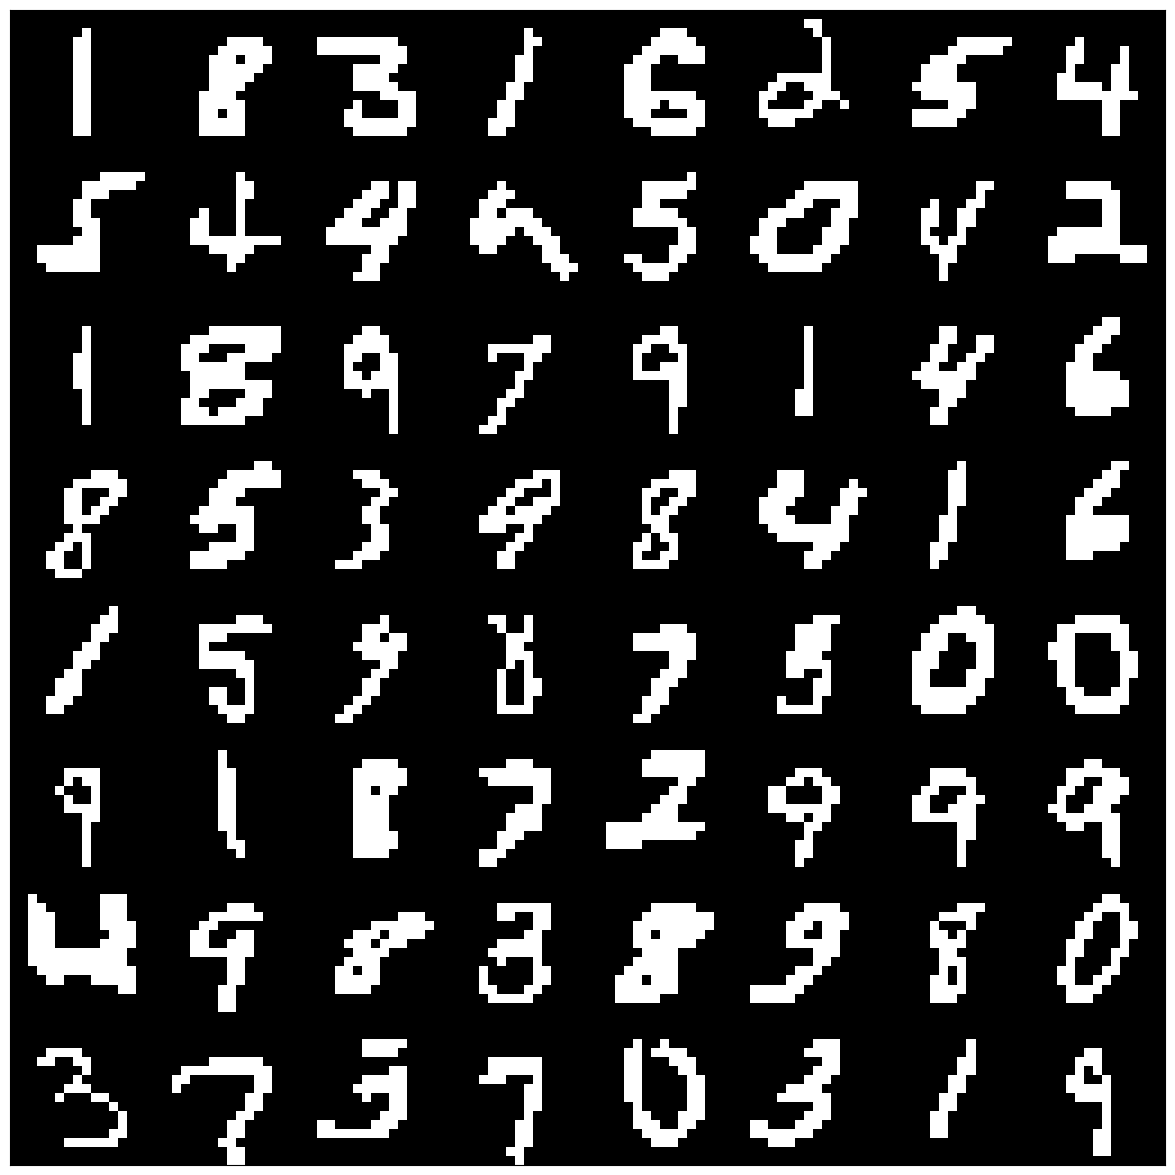

In [183]:
def show_as_image(binary_image, figsize=(10, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(binary_image, cmap='gray')
    plt.xticks([]); plt.yticks([])


batch_images, labels = next(b for b in DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=64))

def batch_images_to_one(batches_images):
    n_square_elements = int(np.sqrt(batches_images.shape[0]))
    rows_images = np.split(np.squeeze(batches_images), n_square_elements)
    return np.vstack([np.hstack(row_images) for row_images in rows_images])


show_as_image(batch_images_to_one(batch_images.numpy()), figsize=(15, 15))

In [ ]:
# zip_path = './data/Font-Awesome-SVG-PNG-master.zip'
# extract_to = './data'

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_to)


# source_dir = './data/Font-Awesome-SVG-PNG-master/black/png/16/'
# target_dir = './data/organized/'
# class_name = 'default_class'

# class_dir = os.path.join(target_dir, class_name)
# os.makedirs(class_dir, exist_ok=True)

# for file_name in os.listdir(source_dir):
#     file_path = os.path.join(source_dir, file_name)
#     if os.path.isfile(file_path):
#       shutil.move(file_path, os.path.join(class_dir, file_name))

In [ ]:
# def show_as_image(binary_image, figsize=(10, 5)):
#     plt.figure(figsize=figsize)
#     plt.imshow(binary_image, cmap='gray')
#     plt.xticks([]); plt.yticks([])

# la_loader = lambda _: Image.open(_).convert('LA')

# image_dataset = datasets.folder.ImageFolder(
#     './data/organized',
#     transform=transforms.Lambda(lambda image: transforms.ToTensor()(image.crop(box=(0, 0, 16, 16)))[1:, :, :] > .5),
#     loader=la_loader)

# batch_images, labels = next(b for b in DataLoader(image_dataset, sampler=RandomSampler(image_dataset), batch_size=64))

# def batch_images_to_one(batches_images):
#     n_square_elements = int(np.sqrt(batches_images.shape[0]))
#     rows_images = np.split(np.squeeze(batches_images), n_square_elements)
#     return np.vstack([np.hstack(row_images) for row_images in rows_images])


# show_as_image(batch_images_to_one(batch_images.numpy()), figsize=(15, 15))

# batch_size = 128

# test_indices = np.random.choice(len(image_dataset),
#                                 replace=False)
# train_indices = np.setdiff1d(np.arange(len(image_dataset)),
#                              test_indices)

# train_loader = DataLoader(image_dataset,
#                           batch_size=batch_size,
#                           shuffle=True
#                           )

# test_loader = DataLoader(image_dataset,
#                          batch_size=batch_size,
#                          shuffle=True)

**2. Реалізація обраної моделі (PixelCNN)**

In [184]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super(MaskedConv2d, self).__init__(*args, **kwargs)
        assert mask_type in {'A', 'B'}
        self.register_buffer('mask', self.weight.data.clone())
        _, _, kH, kW = self.weight.size()
        self.mask.fill_(1)
        self.mask[:, :, kH // 2, kW // 2 + (mask_type == 'B'):] = 0
        self.mask[:, :, kH // 2 + 1:] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)

class PixelCNN(nn.Module):
    n_channels = 16
    kernel_size = 7
    padding = 3
    n_pixels_out = 2 # binary 0/1 pixels

    def __init__(self):
        super(PixelCNN, self).__init__()
        self.layers = nn.Sequential(
            MaskedConv2d('A', in_channels=1, out_channels=self.n_channels, kernel_size=self.kernel_size, padding=self.padding, bias=False), nn.BatchNorm2d(self.n_channels), nn.ReLU(True),
            MaskedConv2d('B', self.n_channels, self.n_channels, kernel_size=self.kernel_size, padding=self.padding, bias=False), nn.BatchNorm2d(self.n_channels), nn.ReLU(True),
            MaskedConv2d('B', self.n_channels, self.n_channels, kernel_size=self.kernel_size, padding=self.padding, bias=False), nn.BatchNorm2d(self.n_channels), nn.ReLU(True),
            MaskedConv2d('B', self.n_channels, self.n_channels, kernel_size=self.kernel_size, padding=self.padding, bias=False), nn.BatchNorm2d(self.n_channels), nn.ReLU(True),
            MaskedConv2d('B', self.n_channels, self.n_channels, kernel_size=self.kernel_size, padding=self.padding, bias=False), nn.BatchNorm2d(self.n_channels), nn.ReLU(True),
            nn.Conv2d(in_channels=self.n_channels, out_channels=self.n_pixels_out, kernel_size=1)
        )

    def forward(self, x):
        pixel_logits = self.layers(x)
        return pixel_logits

**3. Навчання моделі**

In [186]:
model = PixelCNN()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [187]:
num_epochs = 10
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        images = Variable(images).float()
        optimizer.zero_grad()
        loss = F.cross_entropy(input=model(images), target=torch.squeeze(images).long())
        loss.backward()
        optimizer.step()

    test_images = Variable(next(i for i, _ in test_loader)).float()
    test_loss = F.cross_entropy(input=model(test_images), target=torch.squeeze(test_images).long())

    train_losses.append(loss.item())
    test_losses.append(test_loss.item())
    print ('Epoch [%d/%d], Train loss: %.4f, Test loss: %.4f'
           %(epoch+1, num_epochs, loss.item(), test_loss.item()))

Epoch [1/10], Train loss: 0.1361, Test loss: 0.1342
Epoch [2/10], Train loss: 0.1330, Test loss: 0.1313
Epoch [3/10], Train loss: 0.1264, Test loss: 0.1304
Epoch [4/10], Train loss: 0.1275, Test loss: 0.1299
Epoch [5/10], Train loss: 0.1190, Test loss: 0.1261
Epoch [6/10], Train loss: 0.1249, Test loss: 0.1272
Epoch [7/10], Train loss: 0.1273, Test loss: 0.1255
Epoch [8/10], Train loss: 0.1243, Test loss: 0.1260
Epoch [9/10], Train loss: 0.1284, Test loss: 0.1270
Epoch [10/10], Train loss: 0.1227, Test loss: 0.1252


**4. Генерація нових даних**

**5. Оцінка результатів**

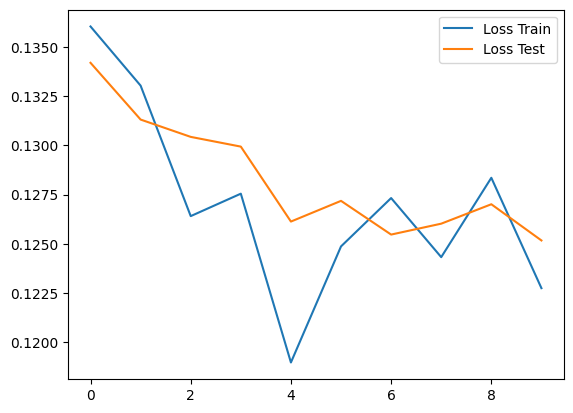

In [188]:
plt.plot(train_losses, label = 'Loss Train')
plt.plot(test_losses, label = 'Loss Test')
plt.legend()
plt.show()

<ipython-input-192-e3fccb31878c>:14: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  out = model(Variable(samples, volatile=True))
<ipython-input-192-e3fccb31878c>:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(out[:, :, i, j]).data


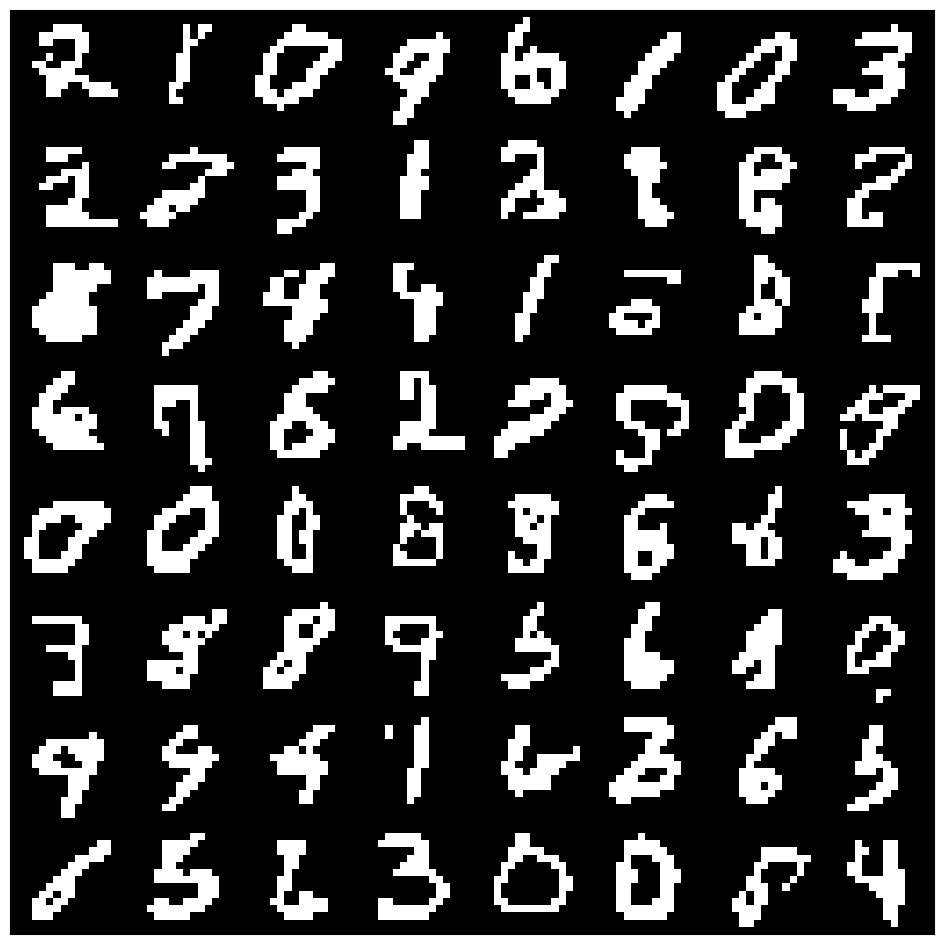

In [192]:
image_width, image_height = 16, 16

def generate_samples(n_samples=8, starting_point=(0, 0), starting_image=None):

    samples = torch.from_numpy(
        starting_image if starting_image is not None else np.zeros((n_samples * n_samples, 1, image_width, image_height))).float()

    model.train(False)

    for i in range(image_width):
        for j in range(image_height):
            if i < starting_point[0] or (i == starting_point[0] and j < starting_point[1]):
                continue
            out = model(Variable(samples, volatile=True))
            probs = F.softmax(out[:, :, i, j]).data
            samples[:, :, i, j] = torch.multinomial(probs, 1).float()
    return samples.numpy()

samples = generate_samples(8)

show_as_image(batch_images_to_one(samples),figsize=(12, 12))

**Порівняння згенеровананих зображення з оригінальними.**

<ipython-input-192-e3fccb31878c>:14: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  out = model(Variable(samples, volatile=True))
<ipython-input-192-e3fccb31878c>:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(out[:, :, i, j]).data


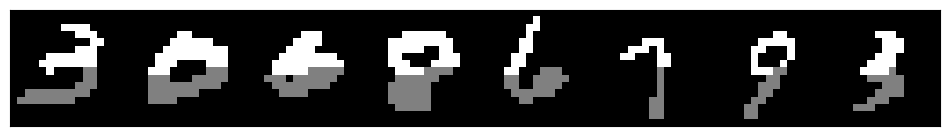

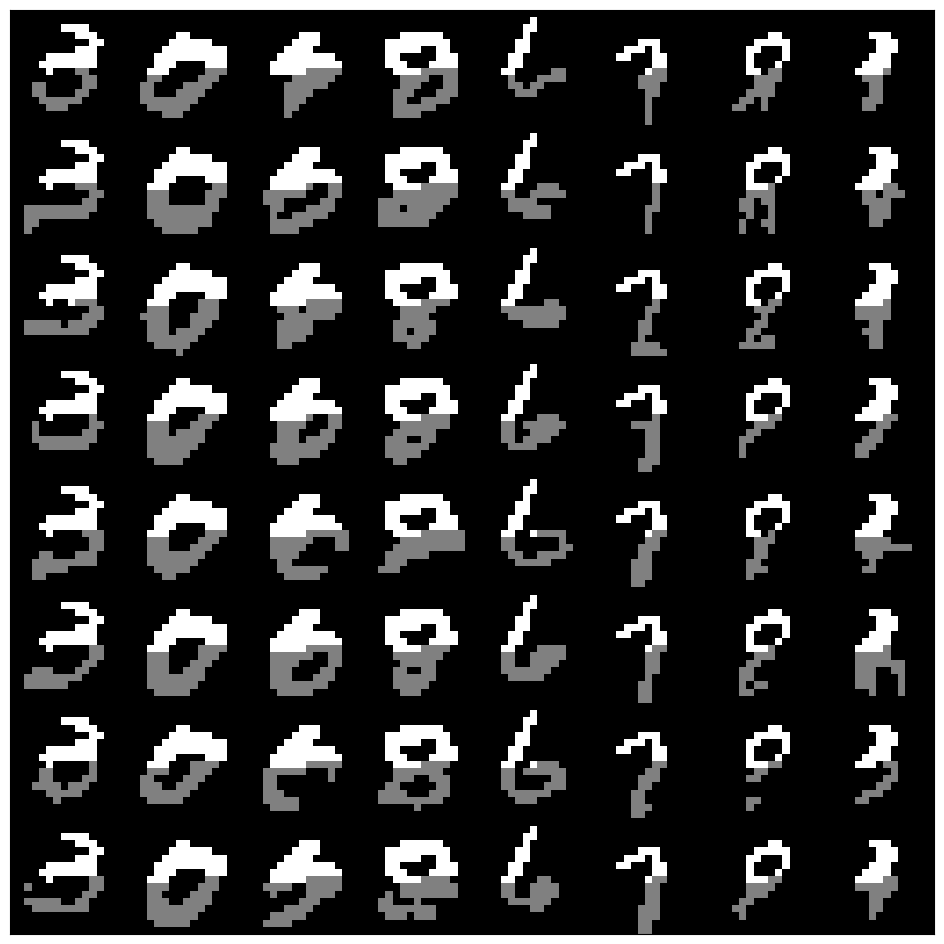

In [195]:
n_images = 8
batch_images, labels = next(b for b in train_loader)
batch_images = batch_images[:n_images, :, :, :]

starting_point = (8, 8)

row_grid, col_grid = np.meshgrid(np.arange(image_width), np.arange(image_height), indexing='ij')
mask = np.logical_or(row_grid < starting_point[0], np.logical_and(row_grid == starting_point[0], col_grid <= starting_point[1]))

starting_images = batch_images.numpy().squeeze()
batch_starting_images = np.expand_dims(np.stack([i * mask for i in starting_images] * n_images), axis=1)

samples = generate_samples(starting_image=batch_starting_images, starting_point=starting_point)

show_as_image(np.hstack([(1 + mask) * i for i in starting_images]), figsize=(12, 12))

show_as_image(
    batch_images_to_one((samples * (1 + mask))),
    figsize=(12, 12))